In [1]:
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import model_selection
from sklearn import preprocessing
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from time import time

In [2]:
#warmstart only useful when you want to add more estimators!
#regr = RandomForestRegressor(n_jobs=-1, random_state=0,n_estimators=100,max_features = 5, warm_start = True)#,oob_score=True, verbose = 1) # verbose only prints time and parallel jobs..oob score doesnt help the fit accuracy
#regr = RandomForestRegressor(n_jobs=-1, random_state=0,n_estimators=500, max_features = "sqrt",warm_start = True, oob_score=True)
regr = KNeighborsRegressor(n_jobs = -1)
lr = LinearRegression()

In [3]:
scores = pd.read_csv('soretdScores.csv', lineterminator='\n')

In [4]:
data = pd.read_csv('motionData.csv', lineterminator='\n')
data.rename(columns={"FFPType\r": "FFPType"},inplace=True)

In [5]:
FEATURES = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"]
FEATURESALL = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType"]

In [6]:
EMOSCORES = ["happier_mu", "sadder_mu", "angrier_mu"]
EMOCONFIDENCE_INV = ["happier_sigma", "sadder_sigma", "angrier_sigma"]
min_confidence = 25/3 # true skill base confidence: http://trueskill.org/
EMOWTS = ["happier_wt", "sadder_wt", "angrier_wt"]

In [7]:
emotionid = 0;

In [8]:
mapper = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], preprocessing.OneHotEncoder())], input_df = True, sparse = True)

In [9]:
transformedData = mapper.fit_transform(data.copy())

In [10]:
WTS= {'happier_wt':(1.5-(scores[EMOCONFIDENCE_INV[0]]/min_confidence)).values,
                   'sadder_wt':(1.5-(scores[EMOCONFIDENCE_INV[1]]/min_confidence)).values,
                'angrier_wt':(1.5-(scores[EMOCONFIDENCE_INV[2]]/min_confidence)).values}
WTS_df = pd.DataFrame(WTS,scores.index)
scores_WTS = pd.concat([scores, WTS_df], axis = 1)

In [11]:
 X_train, X_test, y_train, y_test = model_selection.train_test_split(transformedData, scores_WTS, test_size=0.2, random_state=42)

In [12]:
# use a full grid over all parameters
param_grid = {"n_neighbors": [2,5, 10, 15,20,25,30,35,50,100],
              "weights": ["uniform", "distance"],
             "algorithm": ["auto","kd_tree","brute","ball_tree"]}#,
             #"p":[1,2]}

# run grid search
grid_search = GridSearchCV(regr, param_grid=param_grid, cv=10, n_jobs = -1)
start = time()
grid_search.fit(X_train, y_train[EMOSCORES[emotionid]])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
print(grid_search.cv_results_)

GridSearchCV took 8.05 seconds for 80 candidate parameter settings.
{'param_n_neighbors': masked_array(data = [2 2 5 5 10 10 15 15 20 20 25 25 30 30 35 35 50 50 100 100 2 2 5 5 10 10 15
 15 20 20 25 25 30 30 35 35 50 50 100 100 2 2 5 5 10 10 15 15 20 20 25 25
 30 30 35 35 50 50 100 100 2 2 5 5 10 10 15 15 20 20 25 25 30 30 35 35 50
 50 100 100],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False],
       fill_value = ?)
, 'split0_test_score': array([-0.25072591, -0.22401407, -0.08090789, -0.05153501,  0.16459335,
        0.15278408,  0.19

In [13]:
grid_search.best_estimator_ 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
          weights='distance')

In [14]:
grid_search.best_score_

0.26145492110051699

In [15]:
grid_search.best_params_

{'algorithm': 'auto', 'n_neighbors': 30, 'weights': 'distance'}

In [16]:
#regr.n_estimators = 500
#regr.fit(X_train, y_train[EMOSCORES[emotionid]], sample_weight=y_train[EMOWTS[emotionid]])

In [17]:
lr.fit(X_train, y_train[EMOSCORES[emotionid]],sample_weight=y_train[EMOWTS[emotionid]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
ytest_pred=grid_search.best_estimator_.predict(X_test)
ytrain_pred=grid_search.best_estimator_.predict(X_train)

In [19]:
ytest_pred_lr=lr.predict(X_test)
ytrain_pred_lr=lr.predict(X_train)

In [20]:
print("Mean squared error wtd (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error wtd (test): 21.71
Variance score wtd (test): 0.3844


In [21]:
print("Mean squared error LR wtd (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score LR wtd (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error LR wtd (test): 18.26
Variance score LR wtd (test): 0.4822


In [22]:
print("Mean squared error wtd (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd (train): 0.00
Variance score wtd (train): 1.00


In [23]:
print("Mean squared error wtd LR (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd LR (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd LR (train): 20.57
Variance score wtd LR (train): 0.45


In [24]:
import numpy as np
import matplotlib.pyplot as plt
FEATURENAMES = np.array(["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "walk", "trot", "gallop", "dynamicWalk","walk2","walk2Longswing","walkLongswing"])
LABEL = EMOSCORES[emotionid]

In [25]:
predicted_name ="predicted_"+LABEL

In [26]:
y_hat_regr = pd.DataFrame(ytest_pred, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testregr = pd.concat([y_hat_regr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testregr_sorted = y_all_testregr.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_regr = pd.DataFrame(ytrain_pred, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainregr = pd.concat([ytrain_hat_regr, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainregr_sorted = y_all_trainregr.sort_values(EMOSCORES[emotionid],ascending=[True])

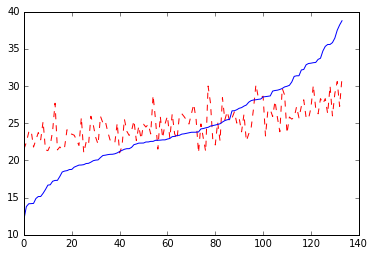

In [27]:
%matplotlib inline
plt.figure()
plt.plot(y_all_testregr_sorted[predicted_name].values,'r--',y_all_testregr_sorted[LABEL].values,'b')

Populating the interactive namespace from numpy and matplotlib


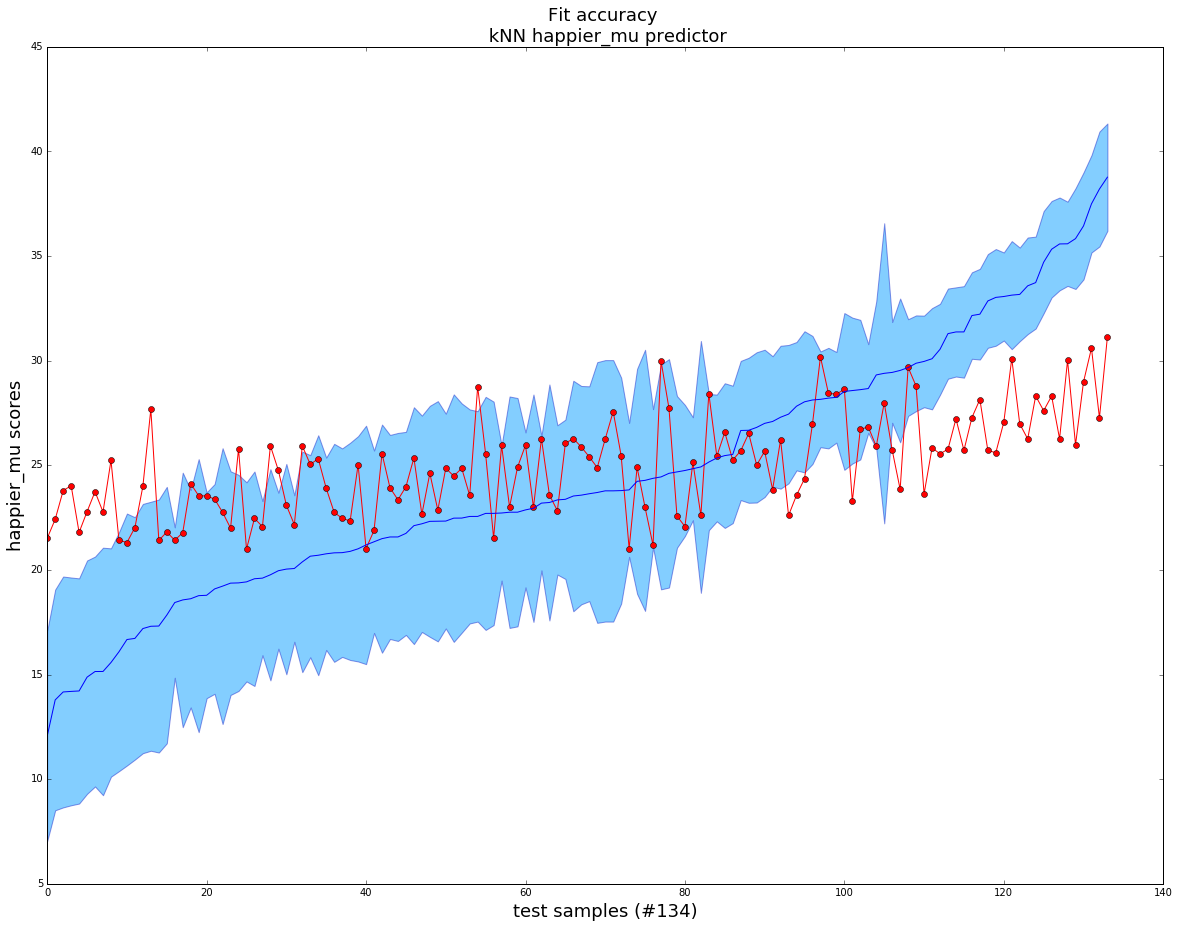

In [28]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testregr_sorted[LABEL].values-y_all_testregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testregr_sorted[LABEL].values+y_all_testregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n kNN ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [29]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainregr_sorted[LABEL].values-y_all_trainregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainregr_sorted[LABEL].values+y_all_trainregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n kNN ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [30]:
y_hat_lr = pd.DataFrame(ytest_pred_lr, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testlr = pd.concat([y_hat_lr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testlr_sorted = y_all_testlr.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_lr = pd.DataFrame(ytrain_pred_lr, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainlr = pd.concat([ytrain_hat_lr, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainlr_sorted = y_all_trainlr.sort_values(EMOSCORES[emotionid],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


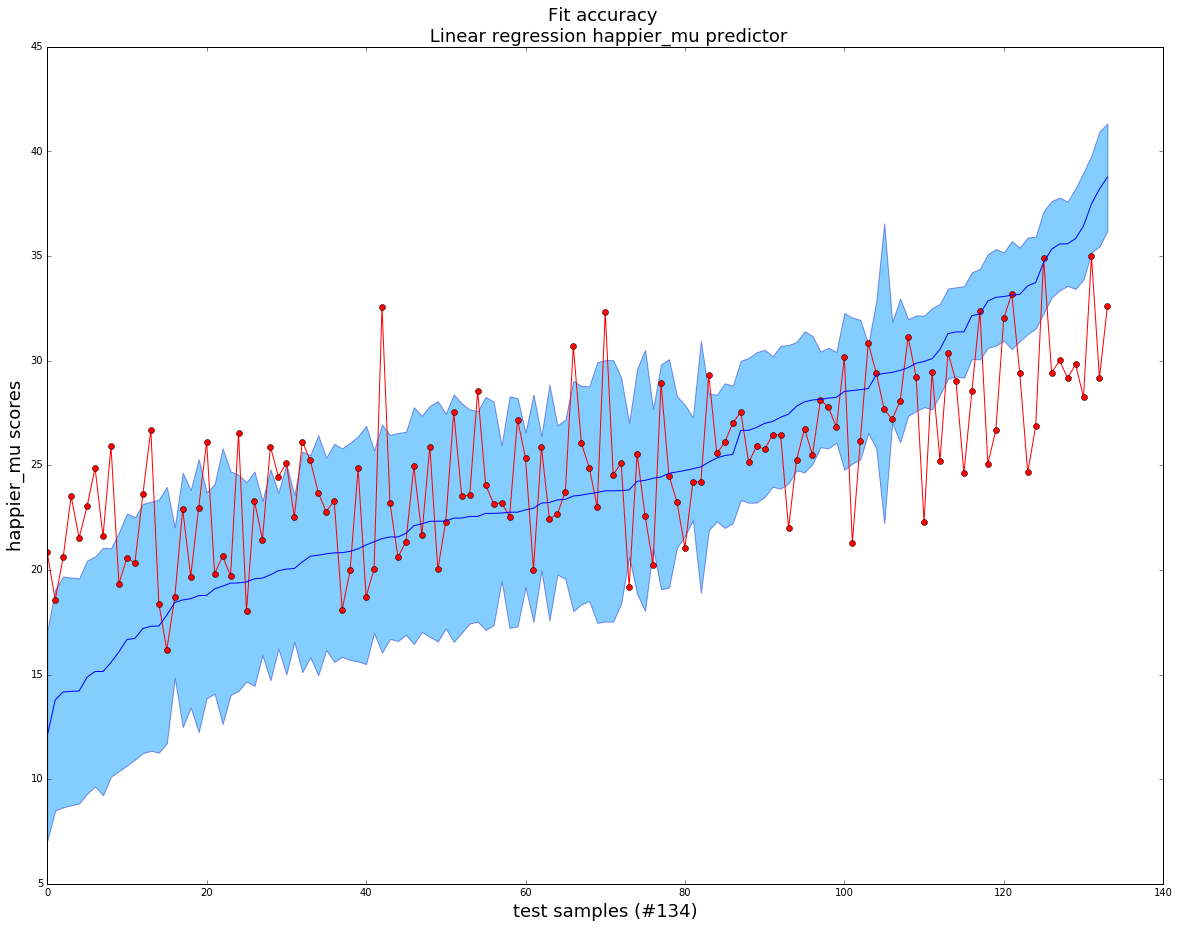

In [31]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testlr_sorted[LABEL].values-y_all_testlr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testlr_sorted[LABEL].values+y_all_testlr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

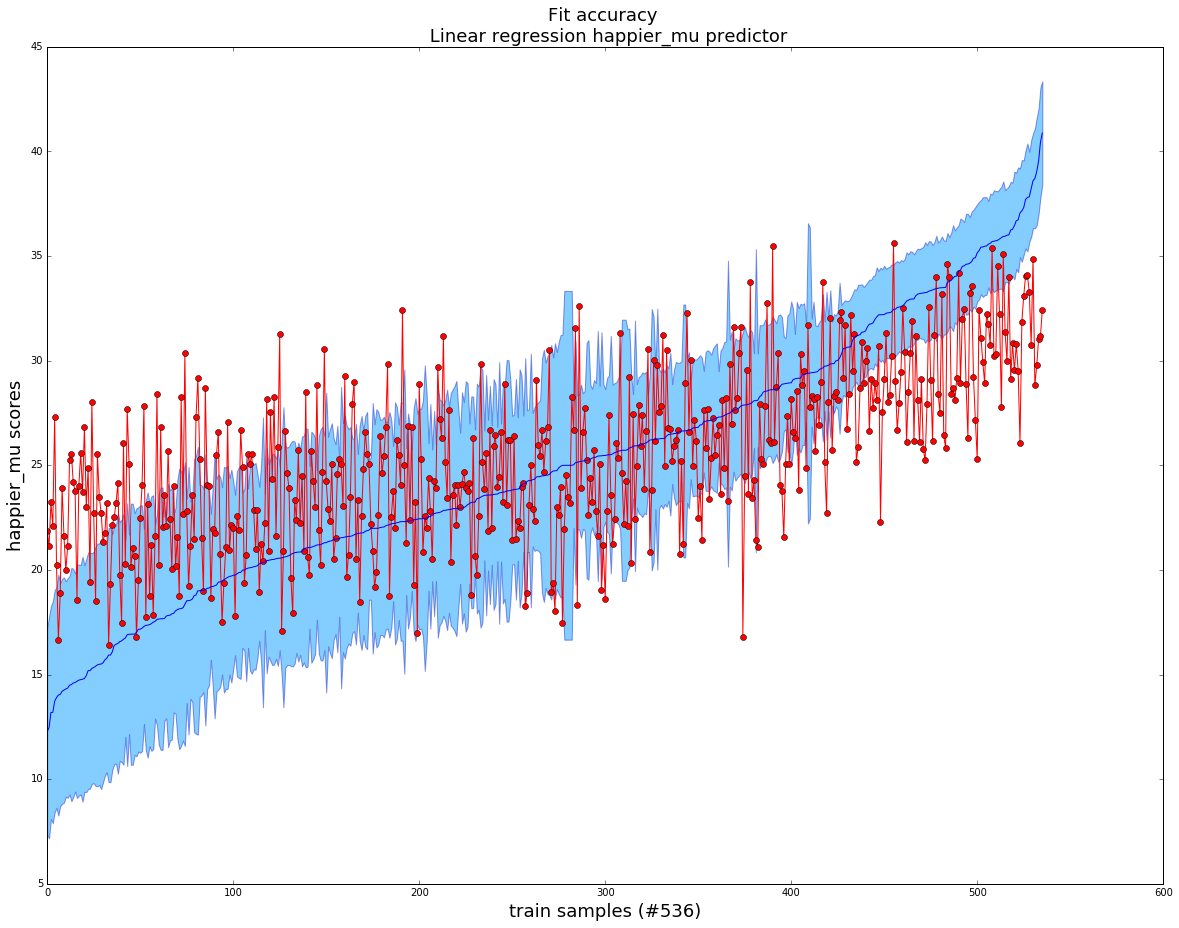

In [32]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainlr_sorted[LABEL].values-y_all_trainlr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainlr_sorted[LABEL].values+y_all_trainlr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainlr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [33]:
bestEstimator_testmse = mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]])
bestEstimator_testr2 = r2_score( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]])

bestEstimator_trainmse = mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]])
bestEstimator_trainr2 = r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]])

In [37]:
bestEstimator_trainmse

0.0

In [40]:
save_info = pd.DataFrame()
regr_info = pd.Series(str(grid_search.best_estimator_.get_params()))

In [41]:
save_info['trained'] = regr_info
save_info['regressor name'] = "kNNRegressor"
save_info['test wtd mse'] = bestEstimator_testmse
save_info['test wtd r2'] = bestEstimator_testr2
save_info['train wtd mse'] = bestEstimator_trainmse
save_info['train wtd r2'] = bestEstimator_trainr2
save_info['emotion'] = "happy"

In [42]:
with open('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\regressorExperiments.csv', 'a') as f:
    save_info.to_csv(f, header=False, index=False)